# DNA Feature Viewer

Using the `dna_features_viewer` library here: https://github.com/Edinburgh-Genome-Foundry/DnaFeaturesViewer

In [3]:
pip install dna_features_viewer

Note: you may need to restart the kernel to use updated packages.


---

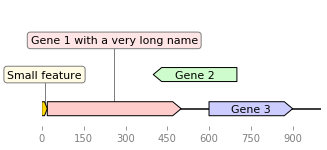

In [4]:
from dna_features_viewer import GraphicFeature, GraphicRecord
features=[
    GraphicFeature(start=0, end=20, strand=+1, color="#ffd700",
                   label="Small feature"),
    GraphicFeature(start=20, end=500, strand=+1, color="#ffcccc",
                   label="Gene 1 with a very long name"),
    GraphicFeature(start=400, end=700, strand=-1, color="#cffccc",
                   label="Gene 2"),
    GraphicFeature(start=600, end=900, strand=+1, color="#ccccff",
                   label="Gene 3")
]
record = GraphicRecord(sequence_length=1000, features=features)
record.plot(figure_width=5);

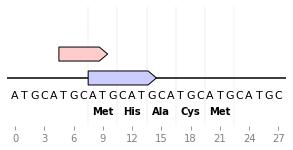

In [5]:
from dna_features_viewer import GraphicFeature, GraphicRecord

sequence = "ATGCATGCATGCATGCATGCATGCATGC"
record = GraphicRecord(sequence=sequence, features=[
    GraphicFeature(start=5, end=10, strand=+1, color='#ffcccc'),
    GraphicFeature(start=8, end=15, strand=+1, color='#ccccff')
])

ax, _ = record.plot(figure_width=5)
record.plot_sequence(ax)
record.plot_translation(ax, (8, 23), fontdict={'weight': 'bold'})
ax.figure.savefig('sequence_and_translation.png', bbox_inches='tight')


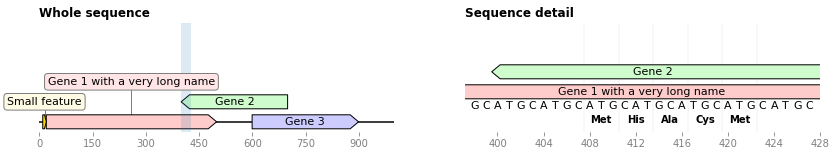

In [6]:
"""Generate a 2-plot figure with full sequence on the left,
detail of a sub-segment on the right."""

from dna_features_viewer import GraphicFeature, GraphicRecord
import matplotlib.pyplot as plt

record = GraphicRecord(sequence=250 * "ATGC", features=[
    GraphicFeature(start=10, end=20, strand=+1, color="#ffd700",
                   label="Small feature"),
    GraphicFeature(start=20, end=500, strand=+1, color="#ffcccc",
                   label="Gene 1 with a very long name"),
    GraphicFeature(start=400, end=700, strand=-1, color="#cffccc",
                   label="Gene 2"),
    GraphicFeature(start=600, end=900, strand=+1, color="#ccccff",
                   label="Gene 3")
])
zoom_start, zoom_end = 398, 428  # coordinates of the "detail"
cropped_record = record.crop((zoom_start, zoom_end))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 2))

# PLOT THE WHOLE SEQUENCE

ax1.set_title("Whole sequence", loc='left', weight='bold')
record.plot(ax=ax1)
ax1.fill_between((zoom_start, zoom_end), +1000, -1000, alpha=0.15)

# PLOT THE SEQUENCE DETAILS


cropped_record.plot_translation(ax=ax2, location=(408, 423),
                                fontdict={'weight': 'bold'})
cropped_record.plot(ax=ax2, plot_sequence=True)
ax2.set_title("Sequence detail", loc='left', weight='bold')

fig.savefig('overview_and_detail.png', bbox_inches='tight')

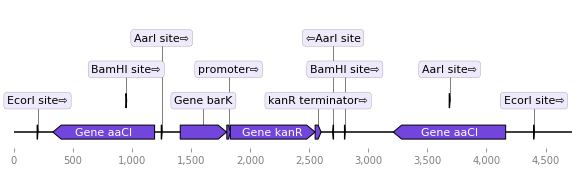

In [11]:
from dna_features_viewer import BiopythonTranslator
graphic_record = BiopythonTranslator().translate_record("examples/example_sequence.gb")
ax, _ = graphic_record.plot(figure_width=10, strand_in_label_threshold=7)

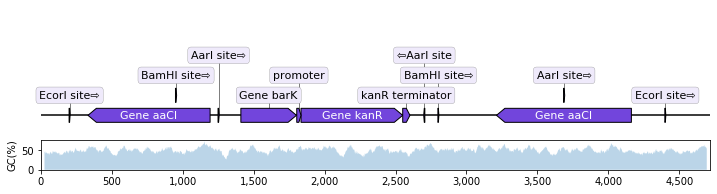

In [13]:
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator
from Bio import SeqIO
import numpy as np

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(12, 3), sharex=True, gridspec_kw={"height_ratios": [4, 1]}
)

# PLOT THE RECORD MAP
record = SeqIO.read("examples/example_sequence.gb", "genbank")
graphic_record = BiopythonTranslator().translate_record(record)
graphic_record.plot(ax=ax1, with_ruler=False, strand_in_label_threshold=4)

# PLOT THE LOCAL GC CONTENT (we use 50bp windows)
gc = lambda s: 100.0 * len([c for c in s if c in "GC"]) / 50
xx = np.arange(len(record.seq) - 50)
yy = [gc(record.seq[x : x + 50]) for x in xx]
ax2.fill_between(xx + 25, yy, alpha=0.3)
ax2.set_ylim(bottom=0)
ax2.set_ylabel("GC(%)");

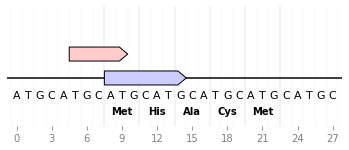

In [9]:
from dna_features_viewer import GraphicFeature, GraphicRecord

record = GraphicRecord(sequence="ATGCATGCATGCATGCATGCATGCATGC", features=[
    GraphicFeature(start=5, end=10, strand=+1, color='#ffcccc'),
    GraphicFeature(start=8, end=15, strand=+1, color='#ccccff')
])

ax, _ = record.plot(figure_width=6)
record.plot_sequence(ax, guides_intensity=0.2)
fontdict = {'weight': 'bold'}
record.plot_translation(ax, (8, 23), fontdict=fontdict, guides_intensity=0.8)
ax.figure.savefig('sequence_and_translation.png', bbox_inches='tight')

In [14]:
pip install moviepy

Note: you may need to restart the kernel to use updated packages.


In [15]:
"""An example with GIF generation at the end. How cool is that!

This example requires the Moviepy library  installed (pip install moviepy).

"""
from Bio import Entrez, SeqIO
import moviepy.editor as mpe
from moviepy.video.io.bindings import mplfig_to_npimage
import matplotlib.pyplot as plt
from dna_features_viewer import BiopythonTranslator, CircularGraphicRecord

# DOWNLOAD THE PLASMID's RECORD FROM NCBI

handle = Entrez.efetch(
    db="nucleotide", id=1473096477, rettype="gb", retmode="text"
)
record = SeqIO.read(handle, "genbank")

# CREATE THE GRAPHIC RECORD WITH DNA_FEATURES_VIEWER

color_map = {
    "rep_origin": "yellow",
    "CDS": "orange",
    "regulatory": "red",
    "misc_recomb": "darkblue",
    "misc_feature": "lightblue",
}
translator = BiopythonTranslator(
    features_filters=(lambda f: f.type not in ["gene", "source"],),
    features_properties=lambda f: {"color": color_map.get(f.type, "white")},
)
translator.max_line_length = 15
graphic_record = translator.translate_record(
    record, record_class=CircularGraphicRecord
)
graphic_record.labels_spacing = 15

# ANIMATE INTO A GIF WITH MOVIEPY

duration = 5


def make_frame(t):
    top_nucleotide_index = t * graphic_record.sequence_length / duration
    graphic_record.top_position = top_nucleotide_index
    ax, _ = graphic_record.plot(figure_width=8, figure_height=11)
    ax.set_ylim(top=2)
    np_image = mplfig_to_npimage(ax.figure)
    plt.close(ax.figure)
    return np_image


clip = mpe.VideoClip(make_frame, duration=duration)
small_clip = clip.crop(x1=60, x2=-60, y1=100, y2=-100).resize(0.5)
small_clip.write_gif("example_with_gif.gif", fps=15)

t:   4%|▍         | 3/75 [00:00<00:04, 17.98it/s, now=None]

MoviePy - Building file example_with_gif.gif with imageio.


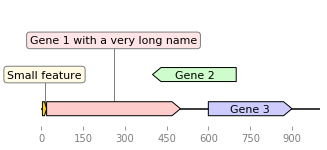

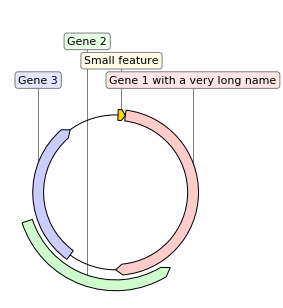

In [16]:
"""Simple example where a few features are defined "by hand" and are displayed
and exported as PNG, first with a linear view, then with a circular
view.
"""

from dna_features_viewer import (
    GraphicFeature,
    GraphicRecord,
    CircularGraphicRecord,
)

features = [
    GraphicFeature(
        start=5, end=20, strand=+1, color="#ffd700", label="Small feature"
    ),
    GraphicFeature(
        start=20,
        end=500,
        strand=+1,
        color="#ffcccc",
        label="Gene 1 with a very long name",
    ),
    GraphicFeature(
        start=400, end=700, strand=-1, color="#cffccc", label="Gene 2"
    ),
    GraphicFeature(
        start=600, end=900, strand=+1, color="#ccccff", label="Gene 3"
    ),
]


# PLOT AND EXPORT A LINEAR VIEW OF THE CONSTRUCT
record = GraphicRecord(sequence_length=1000, features=features)
ax, _ = record.plot(figure_width=5)
ax.figure.savefig("graphic_record_defined_by_hand.png")


# PLOT AND EXPORT A CIRCULAR VIEW OF THE CONSTRUCT
circular_rec = CircularGraphicRecord(sequence_length=1000, features=features)
ax2, _ = circular_rec.plot(figure_width=4)
ax2.figure.tight_layout()
ax2.figure.savefig(
    "graphic_record_defined_by_hand_circular.png", bbox_inches="tight"
)